In [1]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, r'C:\ml-latest-small')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import logging, os

In [3]:
training_full=pd.read_csv(r'C:\ml-latest-small\ratings.csv')

In [4]:
print(training_full.columns)


Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [5]:
training_full

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
print(training_full.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [7]:
correct_column_names = [col for col in training_full.columns if 'UserId' in col]
print(correct_column_names)

[]


In [8]:
user_ids = training_full['userId'].unique().tolist()


In [9]:
# Drop unnecessary columns
cols_to_drop = ['timestamp']
#training_full.drop(cols_to_drop, axis = 1, inplace = True)
training_full.head()

user_ids = training_full["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = training_full["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
training_full["user"] = training_full["userId"].map(user2user_encoded)
training_full["movie"] = training_full["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
training_full["rating"] = training_full["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(training_full["rating"])
max_rating = max(training_full["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

training_full = training_full.sample(frac=1, random_state=42)
x = training_full[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = training_full["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.8 * training_full.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)



Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [10]:
EMBEDDING_SIZE = 64

In [11]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=11,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/11
1261/1261 [==============================] - 21s 15ms/step - loss: 0.6389 - val_loss: 0.6213
Epoch 2/11
1261/1261 [==============================] - 18s 14ms/step - loss: 0.6156 - val_loss: 0.6241
Epoch 3/11
1261/1261 [==============================] - 18s 14ms/step - loss: 0.6118 - val_loss: 0.6156
Epoch 4/11
1261/1261 [==============================] - 18s 14ms/step - loss: 0.6117 - val_loss: 0.6180
Epoch 5/11
1261/1261 [==============================] - 19s 15ms/step - loss: 0.6135 - val_loss: 0.6174
Epoch 6/11
1261/1261 [==============================] - 20s 16ms/step - loss: 0.6136 - val_loss: 0.6177
Epoch 7/11
1261/1261 [==============================] - 18s 15ms/step - loss: 0.6129 - val_loss: 0.6155
Epoch 8/11
1261/1261 [==============================] - 18s 14ms/step - loss: 0.6116 - val_loss: 0.6154
Epoch 9/11
1261/1261 [==============================] - 18s 14ms/step - loss: 0.6137 - val_loss: 0.6175
Epoch 10/11
1261/1261 [==============================] - 19s 15m

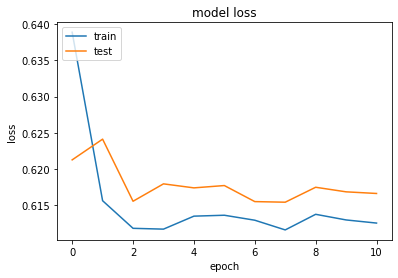

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [13]:
movie_df=pd.read_csv(r'C:\Users\avant\OneDrive\Documents\M.E Project\ml-latest-small\movies.csv')


In [14]:
print(movie_df.columns)

Index(['movieId', 'title', 'genres'], dtype='object')


In [15]:

movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [16]:
# Let us get a user and see the top recommendations.
user_id = 1

movies_watched_by_user = training_full[training_full.userId ==user_id]
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Top 10 movie recommendations
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Rear Window (1954) : Mystery|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
African Queen, The (1951) : Adventure|Comedy|Romance|War
Fish Called Wanda, A (1988) : Comedy|Crime
Dial M for Murder (1954) : Crime|Mystery|Thriller
Graduate, The (1967) : Comedy|Drama|Romance
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Cool Hand Luke (1967) : Drama


In [38]:
# Let us get a user and see the top recommendations.
user_id = 255

movies_watched_by_user = training_full[training_full.userId ==user_id]
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Top 10 movie recommendations
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Secrets & Lies (1996) : Drama
Streetcar Named Desire, A (1951) : Drama
One Flew Over the Cuckoo's Nest (1975) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
High Noon (1952) : Drama|Western
This Is Spinal Tap (1984) : Comedy


In [39]:
# Let us get a user and see the top recommendations.
user_id = 7

movies_watched_by_user = training_full[training_full.userId ==user_id]
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Top 10 movie recommendations
--------------------------------
Fargo (1996) : Comedy|Crime|Drama|Thriller
His Girl Friday (1940) : Comedy|Romance
It's a Wonderful Life (1946) : Children|Drama|Fantasy|Romance
African Queen, The (1951) : Adventure|Comedy|Romance|War
Secrets & Lies (1996) : Drama
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Good Will Hunting (1997) : Drama|Romance
Sweet Hereafter, The (1997) : Drama
Big Lebowski, The (1998) : Comedy|Crime
Doctor Zhivago (1965) : Drama|Romance|War


In [40]:
# Let us get a user and see the top recommendations.
user_id = 255

movies_watched_by_user = training_full[training_full.userId ==user_id]
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Top 10 movie recommendations
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Secrets & Lies (1996) : Drama
Streetcar Named Desire, A (1951) : Drama
One Flew Over the Cuckoo's Nest (1975) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
High Noon (1952) : Drama|Western
This Is Spinal Tap (1984) : Comedy


In [41]:
# Let us get a user and see the top recommendations.
user_id = 500

movies_watched_by_user = training_full[training_full.userId ==user_id]
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Top 10 movie recommendations
--------------------------------
Crumb (1994) : Documentary
Hoop Dreams (1994) : Documentary
Silence of the Lambs, The (1991) : Crime|Horror|Thriller
Fish Called Wanda, A (1988) : Comedy|Crime
Dial M for Murder (1954) : Crime|Mystery|Thriller
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama


In [42]:
# Let us get a user and see the top recommendations.
user_id = 7

movies_watched_by_user = training_full[training_full.userId ==user_id]
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Top 10 movie recommendations
--------------------------------
Fargo (1996) : Comedy|Crime|Drama|Thriller
His Girl Friday (1940) : Comedy|Romance
It's a Wonderful Life (1946) : Children|Drama|Fantasy|Romance
African Queen, The (1951) : Adventure|Comedy|Romance|War
Secrets & Lies (1996) : Drama
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Good Will Hunting (1997) : Drama|Romance
Sweet Hereafter, The (1997) : Drama
Big Lebowski, The (1998) : Comedy|Crime
Doctor Zhivago (1965) : Drama|Romance|War


In [43]:
# Assuming your_dataframe is your DataFrame
import csv

# Open a CSV file in write mode
with open('output1.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Create a CSV writer object
    csvwriter = csv.writer(csvfile)

    # Write the header to the CSV file
    csvwriter.writerow(['title', 'genres'])

    # Iterate over rows and write selected columns to the CSV file
    for index, row in recommended_movies.iterrows():
        csvwriter.writerow([row['title'], row['genres']])

In [44]:
output1=pd.read_csv('output1.csv')

In [45]:
output1.head()

,title,genres
0,Fargo (1996),Comedy|Crime|Drama|Thriller
1,His Girl Friday (1940),Comedy|Romance
2,It's a Wonderful Life (1946),Children|Drama|Fantasy|Romance
3,"African Queen, The (1951)",Adventure|Comedy|Romance|War
4,Secrets & Lies (1996),Drama


In [46]:
output1 = pd.read_csv('output1.csv')

In [47]:
output2 = pd.read_csv('output2.csv')

In [48]:
output1.head()

,title,genres
0,Fargo (1996),Comedy|Crime|Drama|Thriller
1,His Girl Friday (1940),Comedy|Romance
2,It's a Wonderful Life (1946),Children|Drama|Fantasy|Romance
3,"African Queen, The (1951)",Adventure|Comedy|Romance|War
4,Secrets & Lies (1996),Drama


In [49]:
# Load the CSV file into a pandas DataFra
df= pd.read_csv('output1.csv')

# Rename columns as needed
df.rename(columns={'title': 'Title'}, inplace=True)
df.rename(columns={'genres': 'Genre'}, inplace=True)

# Save the modified DataFrame back to the CSV file
df.to_csv(index=False)

'Title,Genre\r\nFargo (1996),Comedy|Crime|Drama|Thriller\r\nHis Girl Friday (1940),Comedy|Romance\r\nIt\'s a Wonderful Life (1946),Children|Drama|Fantasy|Romance\r\n"African Queen, The (1951)",Adventure|Comedy|Romance|War\r\nSecrets & Lies (1996),Drama\r\nChinatown (1974),Crime|Film-Noir|Mystery|Thriller\r\nGood Will Hunting (1997),Drama|Romance\r\n"Sweet Hereafter, The (1997)",Drama\r\n"Big Lebowski, The (1998)",Comedy|Crime\r\nDoctor Zhivago (1965),Drama|Romance|War\r\n'

In [50]:
df.head()

,Title,Genre
0,Fargo (1996),Comedy|Crime|Drama|Thriller
1,His Girl Friday (1940),Comedy|Romance
2,It's a Wonderful Life (1946),Children|Drama|Fantasy|Romance
3,"African Queen, The (1951)",Adventure|Comedy|Romance|War
4,Secrets & Lies (1996),Drama


In [51]:
# Load the CSV file into a pandas DataFrame
df1 = pd.read_csv('output2.csv')

# Rename columns as needed
df1.rename(columns={'title': 'Title', 'genres': 'enres'}, inplace=True)

# Save the modified DataFrame back to a CSV file
df1.to_csv('modified_output2.csv', index=False)

In [52]:
df1.head()

,MovieId,Title,Genre
0,42015,Casanova (2005),Action|Adventure|Comedy|Drama|Romance
1,4956,"Stunt Man, The (1980)",Action|Adventure|Comedy|Drama|Romance|Thriller
2,55116,"Hunting Party, The (2007)",Action|Adventure|Comedy|Drama|Thriller
3,117646,Dragonheart 2: A New Beginning (2000),Action|Adventure|Comedy|Drama|Fantasy|Thriller
4,5657,Flashback (1990),Action|Adventure|Comedy|Crime|Drama


In [53]:
import pandas as pd

# Load the two CSV files into DataFrames
output1 = df
output2 = df1

# Concatenate the DataFrames vertically, ignoring the 'movie id' column from output2
aligned_df = pd.concat([output1, output2[['Title', 'Genre']]], ignore_index=True)



In [54]:
aligned_df = pd.concat([output1, output2[['Title', 'Genre']]], ignore_index=True)

In [55]:
aligned_list = aligned_df.values.tolist()

# Print the list
print(aligned_list)

[['Fargo (1996)', 'Comedy|Crime|Drama|Thriller'], ['His Girl Friday (1940)', 'Comedy|Romance'], ["It's a Wonderful Life (1946)", 'Children|Drama|Fantasy|Romance'], ['African Queen, The (1951)', 'Adventure|Comedy|Romance|War'], ['Secrets & Lies (1996)', 'Drama'], ['Chinatown (1974)', 'Crime|Film-Noir|Mystery|Thriller'], ['Good Will Hunting (1997)', 'Drama|Romance'], ['Sweet Hereafter, The (1997)', 'Drama'], ['Big Lebowski, The (1998)', 'Comedy|Crime'], ['Doctor Zhivago (1965)', 'Drama|Romance|War'], ['Casanova (2005)', 'Action|Adventure|Comedy|Drama|Romance'], ['Stunt Man, The (1980)', 'Action|Adventure|Comedy|Drama|Romance|Thriller'], ['Hunting Party, The (2007)', 'Action|Adventure|Comedy|Drama|Thriller'], ['Dragonheart 2: A New Beginning (2000)', 'Action|Adventure|Comedy|Drama|Fantasy|Thriller'], ['Flashback (1990)', 'Action|Adventure|Comedy|Crime|Drama'], ['Extreme Days (2001)', 'Action|Adventure|Comedy|Drama'], ["Pusher III: I'm the Angel of Death (2005)", 'Action|Comedy|Drama|Horro

In [56]:
import pandas as pd

# Assuming aligned_df is your DataFrame
# Remove duplicates from aligned_df
unique_df = aligned_df.drop_duplicates()

# Iterate over rows and print each row on a single line
for index, row in unique_df.iterrows():
    row_str = ', '.join([f"{col}: {value}" for col, value in row.items()])
    print(row_str)

Title: Fargo (1996), Genre: Comedy|Crime|Drama|Thriller
Title: His Girl Friday (1940), Genre: Comedy|Romance
Title: It's a Wonderful Life (1946), Genre: Children|Drama|Fantasy|Romance
Title: African Queen, The (1951), Genre: Adventure|Comedy|Romance|War
Title: Secrets & Lies (1996), Genre: Drama
Title: Chinatown (1974), Genre: Crime|Film-Noir|Mystery|Thriller
Title: Good Will Hunting (1997), Genre: Drama|Romance
Title: Sweet Hereafter, The (1997), Genre: Drama
Title: Big Lebowski, The (1998), Genre: Comedy|Crime
Title: Doctor Zhivago (1965), Genre: Drama|Romance|War
Title: Casanova (2005), Genre: Action|Adventure|Comedy|Drama|Romance
Title: Stunt Man, The (1980), Genre: Action|Adventure|Comedy|Drama|Romance|Thriller
Title: Hunting Party, The (2007), Genre: Action|Adventure|Comedy|Drama|Thriller
Title: Dragonheart 2: A New Beginning (2000), Genre: Action|Adventure|Comedy|Drama|Fantasy|Thriller
Title: Flashback (1990), Genre: Action|Adventure|Comedy|Crime|Drama
Title: Extreme Days (2001)

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt


y_pred = model.predict(x_val)


y_pred = y_pred.flatten() * (max_rating - min_rating) + min_rating


mse = mean_squared_error(y_val * (max_rating - min_rating) + min_rating, y_pred)


rmse = sqrt(mse)

print("RMSE on the validation set: {}".format(rmse))


RMSE on the validation set: 0.9535050929909736


In [32]:
from sklearn.metrics import classification_report

threshold = 0.5

y_pred = (model.predict(x_val).flatten() >= threshold).astype(int)
y_true = (y_val >= threshold).astype(int)

classification_rep = classification_report(y_true, y_pred)
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.57      0.50      3876
           1       0.89      0.83      0.86     16292

    accuracy                           0.78     20168
   macro avg       0.66      0.70      0.68     20168
weighted avg       0.80      0.78      0.79     20168



In [33]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1 * 100:.2f}%")

F1 Score: 85.74%


In [34]:
from sklearn.metrics import precision_score
precision_score = precision_score(y_true, y_pred)
print(f"Precision: {precision_score * 100:.2f}%")

Precision: 88.96%


In [35]:
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall * 100:.2f}%")

Recall: 82.74%


In [36]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 77.76%


In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
model.fit(x_train, y_train)
model_predictions=model.predict(x_val)

model_recall_score=recall_score(y_true, y_pred)
model_f1_score=f1_score(y_true, y_pred)
model_accuracy=accuracy_score(y_true, y_pred)
model_precision_score=precision_score(y_true, y_pred)


print("Accuracy",model_accuracy)
print("Recall",recall_score)
print("f1 score",f1_score)
print("f1 score",precision_score)

2521/2521 [==============================] - 40s 16ms/step - loss: 0.6025
Accuracy 0.7776180087266957
Recall <function recall_score at 0x0000023CF70B7A60>
f1 score <function f1_score at 0x0000023CF70B7430>
f1 score <function precision_score at 0x0000023CF70B7940>


In [ ]:
from sklearn.metrics import precision_score
model_precision_score=precision_score(y_true, y_pred)
print(f"Precision: {model_precision_score * 100:.2f}%")

In [ ]:
from sklearn.metrics import f1_score
model_f1_score=f1_score(y_true, y_pred)
print(f"f1 score: {model_f1_score * 100:.2f}%")

In [ ]:
from sklearn.metrics import recall_score
model_recall_score=recall_score(y_true, y_pred)
print(f"Recall: {model_recall_score * 100:.2f}%")
